# Process and grade LLM responses

In [191]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from typing import NamedTuple

In [192]:
ROOT = os.path.expanduser("~/biodiversity-llms")
TAXONOMY_TESTSET_SCORES = ROOT + "/tdwg2023/taxonomy/results/kpfg_scores.tsv"
TAXON_COUNTS = ROOT + "/tdwg2023/taxonomy/results/taxon-counts.tsv"

In [193]:
class Files(NamedTuple):
    responses: str

class Env(NamedTuple):
    files: Files
    num_phrasings: int
    phrasings: list[str]
    query_fields: list[str]

if "snakemake" in globals():
    env = Env(
        files=snakemake.input,
        num_phrasings=len(snakemake.params.phrasings),
        phrasings=snakemake.params.phrasings,
        query_fields=snakemake.params.query_fields
    )
else: # Fill in parameters manually for testing outside of snakemake
    env = Env(
        files = Files(
            responses="../../results/gpt-4-1106-preview/all-shuffled.tsv"
        ),
        num_phrasings=7,
        phrasings=[
            "Does {genus} {specificepithet} naturally occur in {county}, {stateprovince}, {country}?",
            "Can species {genus} {specificepithet} be found in {county}, {stateprovince}, {country}?",
            "Is it possible to encounter species {genus} {specificepithet} in {county}, {stateprovince}, {country}?",
            "Is there a presence of species {genus} {specificepithet} within {county}, {stateprovince}, {country}?",
            "Does {county}, {stateprovince}, {country} harbor species {genus} {specificepithet}?",
            "Is species {genus} {specificepithet} present in {county}, {stateprovince}, {country}?",
            "Can one observe species {genus} {specificepithet} in {county}, {stateprovince}, {country}?"
        ],
        query_fields=[
            "kingdom",
            "phylum",
            "family",
            "genus",
            "specificepithet",
            "country",
            "stateprovince",
            "county"
        ]
    )

def nest(level, strings):
    separator = "\n" + "  " * level + "- "
    return separator + separator.join([str(s) for s in strings])

def quote(strings):
    return [f'"{s}"' for s in strings]

print("Job parameters:")
print(f"- Responses to analyze: {env.files.responses}")
print(f"- Query phrasings (count: {env.num_phrasings}):{nest(2, quote(env.phrasings))}")
print(f"- Query fields:{nest(2, quote(env.query_fields))}")


Job parameters:
- Responses to analyze: ../../results/gpt-4-1106-preview/all-shuffled.tsv
- Query phrasings (count: 7):
    - "Does {genus} {specificepithet} naturally occur in {county}, {stateprovince}, {country}?"
    - "Can species {genus} {specificepithet} be found in {county}, {stateprovince}, {country}?"
    - "Is it possible to encounter species {genus} {specificepithet} in {county}, {stateprovince}, {country}?"
    - "Is there a presence of species {genus} {specificepithet} within {county}, {stateprovince}, {country}?"
    - "Does {county}, {stateprovince}, {country} harbor species {genus} {specificepithet}?"
    - "Is species {genus} {specificepithet} present in {county}, {stateprovince}, {country}?"
    - "Can one observe species {genus} {specificepithet} in {county}, {stateprovince}, {country}?"
- Query fields:
    - "kingdom"
    - "phylum"
    - "family"
    - "genus"
    - "specificepithet"
    - "country"
    - "stateprovince"
    - "county"


In [194]:
def count_item(values, item):
    counts = dict(Counter(values).most_common())
    return counts[item] if item in counts else 0

def make_id(df):
    return df.apply(lambda r: hash("".join([str(v) for v in r.values]).lower()), axis=1)

def get_results(responses):
    df = pd.read_csv(open(responses), sep="\t")

    df["phrasing"] = df["question number"].astype(int) % env.num_phrasings
    df["target"] = (df["present"] == "Yes").astype(int) * 2 - 1
    df["query id"] = make_id(df[env.query_fields])

    df["response id"] = make_id(df[["query id", "phrasing"]])
    df = df.groupby("response id").head(1) # Drop responses for repeated questions

    df["scores"] = df["responses"].apply(lambda r: count_item(r.lower().split(), "yes"))
    df["yesnos"] = df["responses"].apply(lambda r: count_item(r.lower().split(), "yes") + count_item(r.lower().split(), "no"))
    df["abstains"] = 10 - df["yesnos"]

    df["prediction"] = df["scores"].apply(lambda x: -1 if x == 0 else 1) #.apply(lambda x: min(1, max(-1, x)))
    df["correct"] = df["prediction"] * df["target"]

    return df

UNUSED_FIELDS = ["query", "responses", "input token count", "output token count"]
res = get_results(env.files.responses)\
    .drop(columns=UNUSED_FIELDS)

# Drop fungi
res = res[~(res["kingdom"] == "fungi")]

# Drop records with the same family and genus, they cause headaches later
res = res[res["genus"].apply(lambda s: s.lower()) != res["family"].apply(lambda s: s.lower())]

print(f"{len(res) / env.num_phrasings:,.0f} records")
print(f"{len(res):,.0f} queries (#records x #phrasings)")
res.head(1)

15,099 records
105,694 queries (#records x #phrasings)


,kingdom,phylum,family,genus,specificepithet,country,stateprovince,county,present,question number,phrasing,target,query id,response id,scores,yesnos,abstains,prediction,correct
7,animalia,porifera,microcionidae,Clathria,aculeofila,Mexico,Nayarit,Bahia De Banderas,Yes,7,0,1,-9112614997047279818,5212465915756776068,0,10,0,-1,-1


In [195]:
def show_accuracies(df, field, title, remap_values={}, format="{:,.2%}"):
    df = pd.DataFrame(
        (df.groupby(field)["correct"].mean() * .5 + .5)
        .rename("Response accuracy")
    ).transpose()
    df.columns.name = title
    df.rename(columns=remap_values, inplace=True)

    display(df.style.format(format))

show_accuracies(res, "phrasing", "Phrasing")
show_accuracies(res, "target", "Actual presence", remap_values={-1: "Absent", 1: "Present"})
show_accuracies(res, "prediction", "Predicted presence", remap_values={-1: "Absent", 1: "Present"})
show_accuracies(res, "kingdom", "Kingdom")

Phrasing,0,1,2,3,4,5,6
Response accuracy,63.50%,67.40%,69.86%,59.04%,62.55%,62.32%,66.27%


Actual presence,Absent,Present
Response accuracy,86.15%,44.31%


Predicted presence,Absent,Present
Response accuracy,58.88%,77.55%


Kingdom,animalia,plantae
Response accuracy,63.95%,65.02%


In [196]:
kpfg_scores = pd.read_csv(open(TAXONOMY_TESTSET_SCORES, "r"), sep="\t")
kpfg_scores["accuracy"] = (1 + kpfg_scores["num_correct"]) / (2 + kpfg_scores["num_response"])
kpfg_scores = kpfg_scores.set_index(["subject rank", "taxon"])

phrasing_avg_pred = res.groupby("query id")["prediction"].mean()
phrasing_var_score = res.groupby("query id")["scores"].var()
record_counts_by_taxon = pd.read_csv(open(TAXON_COUNTS, "r"), sep="\t").set_index(["kingdom", "phylum", "family"])

In [197]:
res.groupby("stateprovince").size().sort_values()

stateprovince
Œle-De-France          7
Santa Ana              7
Sankt-Peterburg        7
Gulf Of Mexico         7
Sankt Gallen           7
                   ...  
Oklahoma            2688
Massachusetts       2863
Texas               3311
Florida             9296
California         11214
Length: 600, dtype: int64

In [199]:
train_kingdoms = [
    # "animalia",
    "plantae",
    # "fungi"
]

test_kingdoms = [
    "animalia",
    "plantae",
    # "fungi"
]

test_fraction = .5

features = [
    "um1_present", # um1: scores
    "um1_absent",
    "um1_either",
    "um2", # um2: number of abstains
    "um3_kingdom", # um3: accuracy by field values
    "um3_phylum",
    # 'um3_family',
    # "um3_country",
    # "um3_stateprovince",
    "um4_agreement", # Variance in scores with phrasing changes
    "um4_score_var",
    'um5_kingdom', # um5: iDigBio record counts by taxonomic ranks
    'um5_phylum',
    'um5_family',
    "um6_phylum", # Accuracy on taxonomy questions
    "um6_family",
    "um6_genus",
    "um7_phylum", # Number of yes-no responses to taxonomy questions
    "um7_family",
    "um7_genus",
]

predictions = {
    -1,
     1
}

only_valid_absences = True

In [198]:
df = res[res["phrasing"] == 0]
df = df[(df["correct"] != 0) * (df["phrasing"] == 0) * df["kingdom"].isin(test_kingdoms)]

def get_acc_by_field(d, field, smoothing=100):
    num_records = d.groupby(field).size()
    num_correct = smoothing + d[d["correct"] == 1].groupby(field).size().reindex(num_records.index).fillna(0)
    num_incorrect = smoothing + d[d["correct"] == -1].groupby(field).size().reindex(num_records.index).fillna(0)
    return num_correct / (num_correct + num_incorrect)

acc_by_rank = pd.Series({rank: get_acc_by_field(df, rank) for rank in ["kingdom", "phylum", "family"]})
acc_by_country = get_acc_by_field(df, "country")
acc_by_stateprovince = get_acc_by_field(df, "stateprovince")

def get_ums(instance):
    # TODO: condition um3 on prediction?
    um5 = record_counts_by_taxon.loc[instance["kingdom"], instance["phylum"], instance["family"]]
    um1_present = instance["scores"]
    um1_absent = 1 if um1_present == 0 else 0

    return pd.Series({
        "um1_present": um1_present,
        "um1_absent": um1_absent,
        "um1_either": um1_present + um1_absent,
        "um2": 1.0 - instance["abstains"] / 10.0,
        "um3_kingdom": acc_by_rank["kingdom"][instance["kingdom"]],
        "um3_phylum": acc_by_rank["phylum"][instance["phylum"]],
        "um3_family": acc_by_rank["family"][instance["family"]],
        "um3_country": acc_by_country[instance["country"]],
        "um3_stateprovince": acc_by_stateprovince[instance["stateprovince"]],
        "um4_agreement": phrasing_avg_pred[instance["query id"]] * -instance["prediction"],
        "um4_score_var": phrasing_var_score[instance["query id"]],
        "um5_kingdom": um5["kingdomCount"],
        "um5_phylum": um5["phylumCount"],
        "um5_family": um5["familyCount"],
        "um6_phylum": kpfg_scores["accuracy"]["phylum"][instance["phylum"].lower()],
        "um6_family": kpfg_scores["accuracy"]["family"][instance["family"].lower()],
        "um6_genus": kpfg_scores["accuracy"]["genus"][instance["genus"].lower()],
        "um7_phylum": kpfg_scores["num_response"]["phylum"][instance["phylum"].lower()] / 10,
        "um7_family": kpfg_scores["num_response"]["family"][instance["family"].lower()] / 40,
        "um7_genus": kpfg_scores["num_response"]["genus"][instance["genus"].lower()] / 50,
    })

train_df = pd.concat([df.apply(lambda row: get_ums(row), axis=1), df], axis=1)

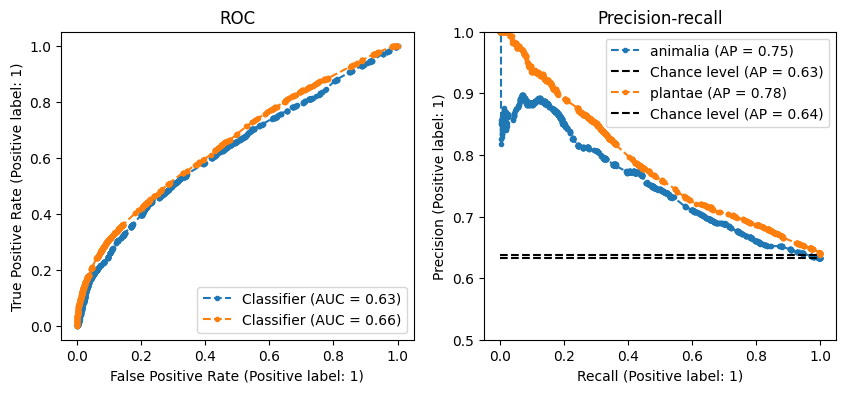

In [201]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
roc_args = {"marker":".", "linestyle":"--"}

if only_valid_absences and "valid" in train_df:
    tdf = train_df[train_df["valid"]]
else:
    tdf = train_df

if len(train_kingdoms) > 0:
    train_set = tdf[tdf["kingdom"].isin(train_kingdoms)]
    test_set = tdf[tdf["kingdom"].isin(test_kingdoms)]
else:
    train_set, test_set = train_test_split(
        tdf[tdf["kingdom"].isin(test_kingdoms) * tdf["prediction"].isin(predictions)],
        test_size=test_fraction
    )

xgboost = HistGradientBoostingClassifier(
    loss='log_loss',
    # early_stopping=True,
    min_samples_leaf=1,
    max_iter=100,
    monotonic_cst=np.ones_like(features, dtype=int)
).fit(train_set[features], train_set["correct"]) # categorical_features=["stateprovince"]

k = test_kingdoms
f, axes = plt.subplots(1, 2, figsize=(10, 4))

if len(k) == 1:
    axes = [axes]

axes[0].title.set_text(f"ROC")
axes[1].title.set_text(f"Precision-recall")

for i, ik in enumerate(k):
    ts = test_set[test_set["kingdom"] == ik]
    probs = xgboost.predict_proba(ts[features])
    RocCurveDisplay.from_predictions(ts["correct"], probs[:,1], ax=axes[0], **roc_args);
    dis = PrecisionRecallDisplay.from_predictions(
        ts["correct"], probs[:,1], name=ik, plot_chance_level=True, drop_intermediate=True, ax=axes[1], drawstyle="default", **roc_args
    )
    axes[1].set_ylim(0.5, 1)
    axes[1].legend()
plt.show()

In [204]:
train_df["certainty"] = xgboost.predict_proba(train_df[features])[:,1]
train_df.to_csv("gpt4.tsv", sep="\t")

In [172]:
df[df["kingdom"] == "animalia"]["phylum"].value_counts()

phylum
annelida         597
mollusca         572
chordata         548
arthropoda       532
brachiopoda      488
bryozoa          426
echinodermata    394
cnidaria         365
porifera         362
Name: count, dtype: int64

In [ ]:
ts = test_set
ts["certainty"] = xgboost.predict_proba(ts[features])[:,1]
ts["correct"] = ts["correct"].clip(0,1)
ts = ts.sort_values("certainty")

pd.DataFrame({
    "Certainty": ts["certainty"],
    "Precision": [ts[ts["certainty"] >= c]["correct"].mean() for c in ts["certainty"]],
    "Trust rate": [ts[ts["certainty"] >= c].index.size / ts.index.size for c in ts["certainty"]]
}).set_index("Certainty").plot()

# Well-calibrated reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
conf_model = (
    "isotonic"
    # "logistic"
)
calibration_set = (
    train_set
    # test_set
)

TODO - It would be better to calibrate on a subset, then test the calibration on the rest

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

# Learn confidence function
rs = calibration_set.copy()
rs["certainty"] = xgboost.predict_proba(rs[features])[:,1]
rs["correct"] = rs["correct"].clip(0,1)
rs = rs.sort_values("certainty")

if conf_model == "isotonic":
    ir = IsotonicRegression(out_of_bounds="clip").fit(rs["certainty"].to_numpy(), rs["correct"].to_numpy())
    calibrate = lambda x: ir.transform(x) 
elif conf_model == "logistic":
    lr = LogisticRegression().fit(rs[["certainty"]].to_numpy(), rs["correct"].to_numpy())
    calibrate = lambda x: lr.predict_proba(x.reshape(-1, 1) if type(x) == np.ndarray else x.to_numpy().reshape(-1, 1))[:,1]
else:
    calibrate = lambda x: 0
    uhoh

# Plot confidence vs. precision
ts["confidence"] = calibrate(ts["certainty"])

pd.DataFrame({
    "Confidence": ts["confidence"],
    "Precision": [ts[ts["confidence"] >= c]["correct"].mean() for c in ts["confidence"]],
    "Trust rate": [ts[ts["confidence"] >= c].index.size / ts.index.size for c in ts["confidence"]]
}).set_index("Confidence").plot()

# Well-calibrated reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.legend(loc="center right")
plt.show()

In [ ]:
calibration_args = {
    "n_bins": 100,
    "strategy": (
        # "uniform"
        "quantile"
    )
}

In [ ]:
args = calibration_args | { "pos_label": 1, "y_true": ts["correct"] }
cert_prob_true, cert = calibration_curve(y_prob=ts["certainty"], **args)
conf_prob_true, conf = calibration_curve(y_prob=ts["confidence"], **args)

print("Certainty ECE:", abs(cert - cert_prob_true).sum() / len(cert))
print("Confidence ECE:", abs(conf - conf_prob_true).sum() / len(conf))

plt.plot(cert, cert_prob_true, label="Accuracy")
plt.plot(cert, calibrate(cert), label="Confidence")
plt.xlabel("Uncertainty bins")
plt.xlim([0,1.01])
plt.ylim([0,1.01])
plt.legend()
plt.show()

In [ ]:
ts[["certainty", "confidence"]].hist(bins=50)